# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import simtk.openmm as mm
from simtk.openmm import app
from simtk import unit
 
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

In [2]:
EmptySnap = paths.snapshot.SnapshotFactory('no', [], 'Empty', use_lazy_reversed=False)

In [3]:
for f, s in EmptySnap.__features__['debug'].iteritems():
    print s
    print 

@staticmethod
def init_copy(self, engine=None):
    self._reversed = None

def create_reversed(self):
    this = cls.__new__(cls)
    this._reversed = self
    return this

def copy_to(self, target):
    this = target
    this._reversed = None
    return this

def init_empty(self):
    self._reversed = None

def copy(self):
    this = cls.__new__(cls)
    this._reversed = None
    return this

def __init__(self, engine=None):
    self._reversed = None



In [4]:
SuperSnap = paths.snapshot.SnapshotFactory(
    'my', [
        paths.features.coordinates,
        paths.features.box_vectors,
        paths.features.velocities
    ], 'No desc', use_lazy_reversed=False)

In [5]:
arr = np.array(range(200000))
brr = np.array(range(200000))

In [6]:
%%timeit
a = SuperSnap(None, arr, arr, arr)

The slowest run took 7.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 689 ns per loop


In [7]:
a = SuperSnap(None, arr, arr, arr)

In [8]:
%%timeit
b = SuperSnap()

The slowest run took 6.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 586 ns per loop


In [9]:
b = SuperSnap()

In [10]:
print id(a.box_vectors)
print id(a.box_vectors.copy())

4940152464
4940152704


In [11]:
x = EmptySnap()

In [12]:
%%timeit
x = EmptySnap()

The slowest run took 7.56 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 410 ns per loop


In [13]:
%%timeit
x.reversed

The slowest run took 27.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 285 ns per loop


In [14]:
%%timeit
a.reversed

The slowest run took 1163.48 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 279 ns per loop


In [15]:
x.reversed.reversed is x

True

In [16]:
%%timeit
EmptySnap.__init__(x)

The slowest run took 33.70 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 262 ns per loop


In [17]:
%%timeit
SuperSnap.__init__(b, None, arr, arr, arr)

The slowest run took 24.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 485 ns per loop


In [18]:
%%timeit
c = a.copy()

The slowest run took 16.69 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 714 ns per loop


In [19]:
%%timeit
a.copy_to(b)

The slowest run took 7.35 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 973 ns per loop


In [20]:
%%timeit
SuperSnap.init_copy(a, None, arr, arr, arr)

The slowest run took 23.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 945 ns per loop


In [21]:
%%timeit
SuperSnap.init_empty(a)

The slowest run took 21.03 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 238 ns per loop


Radians to Degree conversion

In [22]:
deg = 3.14159265 / 180.0

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [23]:
template = paths.tools.snapshot_from_pdb("../data/Alanine_solvated.pdb")

In [24]:
storage = paths.Storage(filename="trajectory.nc", template=template, mode='w')

Set up the OpenMM simulation

In [25]:
topology = paths.tools.to_openmm_topology(template)            

# Generated using OpenMM Script Builder
# http://builder.openmm.org

forcefield = app.ForceField(
    'amber96.xml',  # solute FF
    'tip3p.xml'     # solvent FF
)

# OpenMM System
system = forcefield.createSystem(
    topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, 
    constraints=app.HBonds, 
    rigidWater=True, 
    ewaldErrorTolerance=0.0005
)

# OpenMM Integrator
integrator = mm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)

# Engine options
options = {
    'nsteps_per_frame': 10,
    'platform': 'CUDA'
}

engine = paths.OpenMMEngine(
    template, 
    system,
    integrator,
    options
)

In [26]:
print storage.save(engine)

(store.engines[DynamicsEngine], 11, 0)


### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [27]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MDTraj_Function("psi", md.compute_dihedrals, indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = paths.CV_MDTraj_Function("phi", md.compute_dihedrals, indices=[phi_atoms])

In [28]:
def pp2_fnc(item, psi, phi):
    return psi(item)**2 + phi(item)**2

pp2 = paths.CV_Function('psi2', pp2_fnc, psi=psi, phi=phi)

In [29]:
storage.save(pp2)

(store.cvs[CollectiveVariable], 6, 0)

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

StateA is $\psi \in [-120, -30]$ and StateB is $\psi \in [100, 180]$

In [30]:
stateA = paths.CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0*deg, 
    lambda_max=-30.0*deg, 
    period_min=-180.0*deg, 
    period_max=+180.0*deg
)
stateB = paths.CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=100.0*deg, 
    lambda_max=180.0*deg, 
    period_min=-180.0*deg, 
    period_max=+180.0*deg
)

Now do the same for a set of lambda ranges to produce nested volumes.

In [31]:
minima = map(deg.__mul__, [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])
maxima = map(deg.__mul__, [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = paths.VolumeFactory.CVRangeVolumePeriodicSet(psi, minima, maxima, -180.0*deg, +180.0*deg)

Tag the two states for simpler access later

In [32]:
storage.tag['stateA'] = stateA
storage.tag['stateB'] = stateB
storage.tag['states'] = [stateA, stateB]

### Ensembles

Now do this automatically for all ensembles

In [33]:
interface0 = volume_set[0]
interface_set = paths.EnsembleFactory.TISEnsembleSet(stateA, stateA | stateB, volume_set, psi)

Give each interface a name

In [34]:
for no, interface in enumerate(interface_set):
    interface.name = 'Interface ' + str(no)

and save all of these

In [35]:
map(storage.ensembles.save, interface_set);

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [36]:
inA = paths.AllInXEnsemble(stateA)
outA = paths.AllOutXEnsemble(stateA)

inI0 = paths.AllInXEnsemble(interface0)
outI0 = paths.AllOutXEnsemble(interface0)

first_traj_ensemble = paths.SequentialEnsemble([
    paths.OptionalEnsemble(outA),
    inA,
    paths.OptionalEnsemble(outA & inI0),
    paths.OptionalEnsemble(inI0),
    outI0,
    paths.OptionalEnsemble(outA),
    paths.SingleFrameEnsemble(inA)
])

### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [44]:
snapshot = storage.template
total_path = engine.generate_forward(snapshot, first_traj_ensemble)

Show the length

In [56]:
print "Total trajectory length : %d ( %s )" % ( 
    len(total_path), 
    len(total_path) * engine.options['nsteps_per_frame'] * engine.simulation.integrator.getStepSize()
)

Total trajectory length : 118 ( 2.36 ps )


And save the trajetory completely

In [59]:
storage.save(total_path);

In [60]:
storage.tag['first_path'] = total_path

RuntimeWarning: Cannot re-save existing key "first_path" in immutable dict store.

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [80]:
%%time
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

CPU times: user 233 ms, sys: 59.2 ms, total: 293 ms
Wall time: 253 ms


In [81]:
print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 5


Show some results and check if this worked

In [83]:
data = []
for frame in total_path:
    data.append((phi(frame) / deg, psi(frame)/deg, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208455,-10.277032,False,False,False,True
1,-82.969498,-10.806646,False,False,False,True
2,-79.326288,-13.611584,False,False,False,True
115,-64.703256,-22.422983,False,False,False,True
116,-57.691610,-24.288407,False,False,False,True
117,-55.761501,-30.225681,True,True,False,False


In [84]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [85]:
data = []
for frame in segments[0]:
    data.append((phi(frame)/deg, psi(frame)/deg, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-48.984795,-36.656433,True,True,False,True
1,-55.398158,-25.275883,False,True,False,True
2,-64.703256,-22.422983,False,False,False,True
3,-57.691610,-24.288407,False,False,False,True
4,-55.761501,-30.225681,True,True,False,False


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [86]:
mover_set = paths.PathMoverFactory.OneWayShootingSet(paths.UniformSelector(), interface_set)

In [87]:
bootstrap = paths.Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

In [94]:
bootstrap.run(10)

DONE! Completed Bootstrapping cycle step 139 in ensemble 5/7 .



### Save all computed phi/psi values which depends on whether they have been needed before

In [28]:
storage.cvs.sync()

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [29]:
op_inA = paths.CV_Volume('StateA', stateA)
op_inB = paths.CV_Volume('StateB', stateB)
op_notinAorB = paths.CV_Volume('StateX', ~ (stateA | stateB))

Save the new collectivevariables

In [30]:
storage.save([op_inA, op_inB, op_notinAorB]);

Compute the collectivevariable for all snapshots

In [31]:
psi(storage.snapshots.all());
phi(storage.snapshots.all());

In [32]:
op_inA(storage.snapshots.all())
op_inB(storage.snapshots.all())
op_notinAorB(storage.snapshots.all());

In [33]:
storage.cvs.sync()
storage.sync()

In [34]:
storage.close()

In [35]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG
import mdtraj

In [36]:
storage = paths.AnalysisStorage('trajectory.nc')

## Visualization

Create a PathTree generator

In [37]:
tree = PathTreeBuilder(storage)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [38]:
tree.rejected = False
tree.states = [ ('orange',storage.cvs[3])]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = lambda snap : snap.configuration.idx(storage.configurations)
samps = tree.construct_heritage(storage.samples.last)
tree.from_samples(samps)
#for sset in storage.samplesets:
#    print sset.movepath
    
#for s in samps:
#    print (s, s.ensemble.idx[storage], s.replica, len(tree.construct_heritage(s)), s.mover.__class__.__name__)

Render the tree

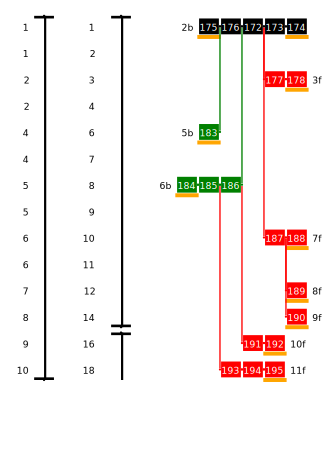

In [39]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 20
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

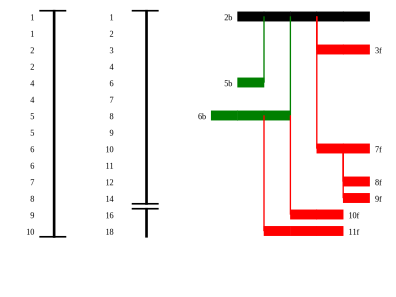

In [40]:
tree.rejected = False
tree.states = []
tree.op = None
tree.from_samples(samps)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.5
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [41]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Make sure that all phi/psi values have been computed!

In [42]:
psi = storage.cvs['psi']
phi = storage.cvs['phi']
opA = storage.cvs['StateA']

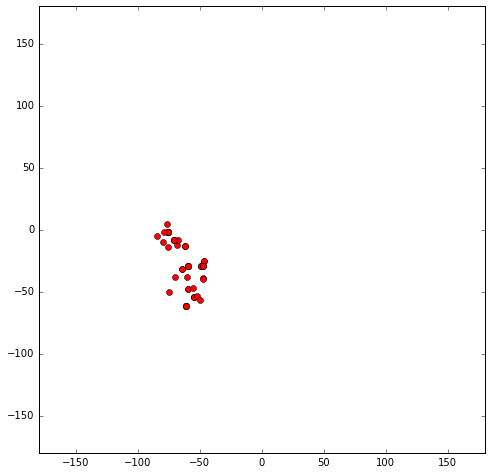

In [43]:
plt.figure(figsize=(8, 8))

for traj in storage.trajectories[1:]:
    phi_angles = np.array(phi(traj)).flatten() / deg
    psi_angles = np.array(psi(traj)).flatten() / deg
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

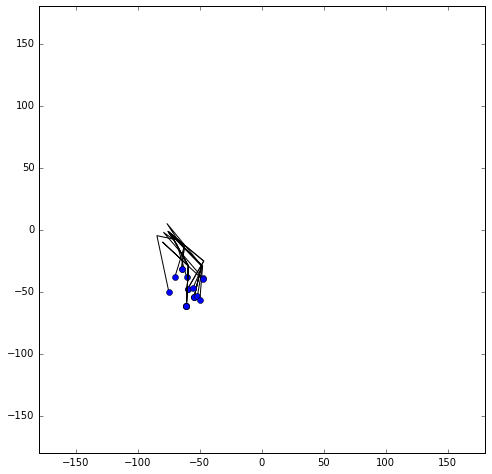

In [44]:
plt.figure(figsize=(8, 8))


for traj in storage.trajectories[1:]:
    phi_angles = np.array(phi(traj)).flatten() / deg
    psi_angles = np.array(psi(traj)).flatten() / deg
    plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);
    for idx, snapshot in enumerate(traj):
        if opA(snapshot):
            plt.plot(phi_angles[idx], psi_angles[idx], 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

In [45]:
#! skip
storage.close()